In [1]:
from flask import (
    Flask,
    render_template,
    jsonify)
from flask_pymongo import PyMongo
import pandas as pd
from pymongo import MongoClient
import json
from bson import json_util
from bson.json_util import dumps
#import dash
#import dash_core_components as dcc
#import dash_html_components as html
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np #importing Numpy
%matplotlib inline 

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #initiating VADER instance

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize  # to split sentences into words
from nltk.corpus import stopwords  # to get a list of stopwords
from collections import Counter  # to get words-frequency


analyser = SentimentIntensityAnalyzer()

app = Flask(__name__)

analyser = SentimentIntensityAnalyzer()

mongo = PyMongo(app, uri="mongodb://localhost:27017/billboard_db")
music = mongo.db.all_number_one_songs
word = mongo.db.word_cloud_data

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nlgrove\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nlgrove\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nlgrove\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.DataFrame(list(music.find()))

In [5]:
df = df.drop(['_id'], axis=1)

In [6]:
len(df)

1203

In [7]:
df.isna().sum()

artist        0
issue_date    0
lyrics        0
title         0
year          0
dtype: int64

In [8]:
####dropping rows with null values
reduced_df = df.dropna(how='any')

In [9]:
reduced_df.isna().sum()

artist        0
issue_date    0
lyrics        0
title         0
year          0
dtype: int64

In [10]:
reduced_df.head(200)

,artist,issue_date,lyrics,title,year
0,Ricky Nelson,"[August 4, August 11]",I used to play around with hearts That hasten...,Poor Little Fool,1958
1,Domenico Modugno,[August 18],Penso che un sogno così non ritorni mai più M...,Nel Blu Dipinto Di Blu (Volaré),1958
2,The Elegants,[August 25],Where are you little star (Where are you )Who...,Little Star,1958
3,Domenico Modugno,"[September 1, September 8, September 15, Septe...",Penso che un sogno così non ritorni mai più Mi...,Nel Blu Dipinto Di Blu (Volaré),1958
4,Tommy Edwards,"[September 29, October 6, October 13, October ...",Many a tear has to fall but it's all in the ga...,It's All In The Game,1958
5,Conway Twitty,[November 10],People see us everywhere They think you reall...,It's Only Make Believe,1958
6,The Kingston Trio,[November 17],Throughout history there have been many songs ...,Tom Dooley,1958
7,Conway Twitty,[November 24],People see us everywhere They think you really...,It's Only Make Believe,1958
8,The Teddy Bears,"[December 1, December 8, December 15]",To know know know him Is to love love lov...,"To Know Him, Is To Love Him",1958
9,The Chipmunks With David Seville,"[December 22, December 29]",All right you Chipmunks! Ready to sing your so...,The Chipmunk Song,1958


In [11]:
len(reduced_df)

1203

In [12]:
lyrics_index = reduced_df.set_index("lyrics")

In [13]:
%time   #to calulate the time it takes the algorithm to compute a VADER score

i=0 #counter

compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(reduced_df)):

    k = analyser.polarity_scores(reduced_df.iloc[i]['lyrics'])
    compval1.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval1 = np.array(compval1)

len(compval1)

Wall time: 0 ns


1203

In [14]:
compval1

array([-0.9959,  0.    ,  0.9911, ...,  0.9984,  0.9906,  0.9991])

In [15]:
reduced_df['VADER'] = compval1

In [16]:
%time

#Assigning score categories and logic
i = 0
predicted_value =[]

while(i<len(reduced_df)):
    if ((reduced_df.iloc[i]['VADER'] >= 0.5)):
        predicted_value.append('positive')
        i = i+1
    elif ((reduced_df.iloc[i]['VADER'] > 0) & (reduced_df.iloc[i]['VADER'] < 0.5)):
        predicted_value.append('neutral')
        i = i+1
    elif ((reduced_df.iloc[i]['VADER'] == 0)):
        predicted_value.append('NA')
        i = i+1
    elif ((reduced_df.iloc[i]['VADER'] < 0)):
        predicted_value.append('negative')
        i = i+1

Wall time: 0 ns


In [17]:
reduced_df['sentiment'] = predicted_value

In [18]:
reduced_df.head(20)

,artist,issue_date,lyrics,title,year,VADER,sentiment
0,Ricky Nelson,"[August 4, August 11]",I used to play around with hearts That hasten...,Poor Little Fool,1958,-0.9959,negative
1,Domenico Modugno,[August 18],Penso che un sogno così non ritorni mai più M...,Nel Blu Dipinto Di Blu (Volaré),1958,0.0000,NA
2,The Elegants,[August 25],Where are you little star (Where are you )Who...,Little Star,1958,0.9911,positive
3,Domenico Modugno,"[September 1, September 8, September 15, Septe...",Penso che un sogno così non ritorni mai più Mi...,Nel Blu Dipinto Di Blu (Volaré),1958,0.0000,NA
4,Tommy Edwards,"[September 29, October 6, October 13, October ...",Many a tear has to fall but it's all in the ga...,It's All In The Game,1958,0.9822,positive
5,Conway Twitty,[November 10],People see us everywhere They think you reall...,It's Only Make Believe,1958,0.9870,positive
6,The Kingston Trio,[November 17],Throughout history there have been many songs ...,Tom Dooley,1958,-0.9984,negative
7,Conway Twitty,[November 24],People see us everywhere They think you really...,It's Only Make Believe,1958,0.9944,positive
8,The Teddy Bears,"[December 1, December 8, December 15]",To know know know him Is to love love lov...,"To Know Him, Is To Love Him",1958,0.9954,positive
9,The Chipmunks With David Seville,"[December 22, December 29]",All right you Chipmunks! Ready to sing your so...,The Chipmunk Song,1958,0.9895,positive


In [19]:
reduced_df.drop(reduced_df[reduced_df['sentiment'] == 'NA'].index , inplace=True)

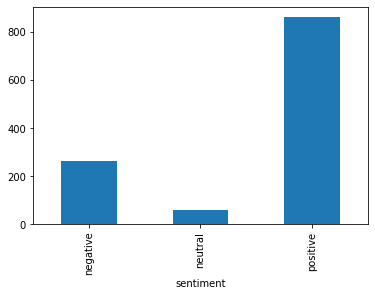

In [20]:
reduced_df.groupby('sentiment').size().plot(kind='bar')

In [21]:
plt.savefig('sentiment.png')

<Figure size 432x288 with 0 Axes>

In [22]:
bins = [1950,1960,1970,1980,1990,2000,2010,2020]
group_names =["50s","60s","70s","80s","90s","2000s","2010s"]
# Slice the data and place it into bins
reduced_df["decade"] = pd.cut(reduced_df["year"], bins, labels=group_names, right=False)


In [23]:
music.delete_many({})

In [24]:
music.insert_many(reduced_df.to_dict('records'))

In [25]:
    df60s = reduced_df[reduced_df['decade']=='60s']
    comment_words =''
# iterate through the csv file 
    for val in df60s['lyrics']: 
      
    # typecaste each val to string 
        val = str(val) 
  
    # split the value 
        tokens = val.split() 
      
    # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
          
        for words in tokens: 
            comment_words = comment_words + words + ' '

    words = word_tokenize(comment_words)

        # get stopwords
    stop_words = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words = [word for word in words if word not in stop_words and len(word) > 3]

        # now, get the words and their frequency
    words_freq = Counter(words)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json = [{'text': word, 'weight': count, 'decade':'60s'} for word, count in words_freq.items()]
    newlist = sorted(words_json, key=lambda i: i['weight'],reverse=True) 
    finallist = newlist[:100]
    df70s = reduced_df[reduced_df['decade']=='70s']

    comment_words1 =''
# iterate through the csv file 
    for val1 in df70s['lyrics']: 
      
    # typecaste each val to string 
        val1 = str(val1) 
  
    # split the value 
        tokens1 = val1.split() 
      
    # Converts each token into lowercase 
        for l in range(len(tokens1)): 
            tokens1[l] = tokens1[l].lower() 
          
        for words1 in tokens1: 
            comment_words1 = comment_words1 + words1 + ' '
    words1 = word_tokenize(comment_words1)

    
    
        # get stopwords
    stop_words1 = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words1 = [word1 for word1 in words1 if word1 not in stop_words1 and len(word1) > 3]

        # now, get the words and their frequency
    words_freq1 = Counter(words1)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json1 = [{'text': word, 'weight': count, 'decade':'70s'} for word, count in words_freq1.items()]
    newlist1 = sorted(words_json1, key=lambda i: i['weight'],reverse=True) 
    finallist1 = newlist1[:100]

    df80s = reduced_df[reduced_df['decade']=='80s']

    comment_words2 =''
# iterate through the csv file 
    for val2 in df80s['lyrics']: 
      
    # typecaste each val to string 
        val2 = str(val2) 
  
    # split the value 
        tokens2 = val2.split() 
      
    # Converts each token into lowercase 
        for m in range(len(tokens2)): 
            tokens2[m] = tokens2[m].lower() 
          
        for words2 in tokens2: 
            comment_words2 = comment_words2 + words2 + ' '
    words2 = word_tokenize(comment_words2)

    
    
        # get stopwords
    stop_words2 = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words2 = [word2 for word2 in words2 if word2 not in stop_words2 and len(word2) > 3]

        # now, get the words and their frequency
    words_freq2 = Counter(words2)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json2 = [{'text': word, 'weight': count, 'decade':'80s'} for word, count in words_freq2.items()]
    newlist2 = sorted(words_json2, key=lambda i: i['weight'],reverse=True) 
    finallist2 = newlist2[:100]
    df90s = reduced_df[reduced_df['decade']=='90s']

    comment_words3 =''
# iterate through the csv file 
    for val3 in df90s['lyrics']: 
      
    # typecaste each val to string 
        val3 = str(val3) 
  
    # split the value 
        tokens3 = val3.split() 
      
    # Converts each token into lowercase 
        for n in range(len(tokens3)): 
            tokens3[n] = tokens3[n].lower() 
          
        for words3 in tokens3: 
            comment_words3 = comment_words3 + words3 + ' '
    words3 = word_tokenize(comment_words3)

    
    
        # get stopwords
    stop_words3 = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words3 = [word3 for word3 in words3 if word3 not in stop_words3 and len(word3) > 3]

        # now, get the words and their frequency
    words_freq3 = Counter(words3)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json3 = [{'text': word, 'weight': count, 'decade':'90s'} for word, count in words_freq3.items()]
    newlist3 = sorted(words_json3, key=lambda i: i['weight'],reverse=True) 
    finallist3 = newlist3[:100]
    df2000s = reduced_df[reduced_df['decade']=='2000s']

    comment_words4 =''
# iterate through the csv file 
    for val4 in df2000s['lyrics']: 
      
    # typecaste each val to string 
        val4 = str(val4) 
  
    # split the value 
        tokens4 = val4.split() 
      
    # Converts each token into lowercase 
        for o in range(len(tokens4)): 
            tokens4[o] = tokens4[o].lower() 
          
        for words4 in tokens4: 
            comment_words4 = comment_words4 + words4 + ' '
    words4 = word_tokenize(comment_words4)

    
    
        # get stopwords
    stop_words4 = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words4 = [word4 for word4 in words4 if word4 not in stop_words4 and len(word4) > 3]

        # now, get the words and their frequency
    words_freq4 = Counter(words4)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json4 = [{'text': word, 'weight': count, 'decade':'2000s'} for word, count in words_freq4.items()]
    newlist4 = sorted(words_json4, key=lambda i: i['weight'],reverse=True) 
    finallist4 = newlist4[:100]
    
    df2010s = reduced_df[reduced_df['decade']=='2010s']

    comment_words5 =''
# iterate through the csv file 
    for val5 in df2010s['lyrics']: 
      
    # typecaste each val to string 
        val5 = str(val5) 
  
    # split the value 
        tokens5 = val5.split() 
      
    # Converts each token into lowercase 
        for p in range(len(tokens5)): 
            tokens5[p] = tokens5[p].lower() 
          
        for words5 in tokens5: 
            comment_words5 = comment_words5 + words5 + ' '
    words5 = word_tokenize(comment_words5)

    
    
        # get stopwords
    stop_words5 = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words5 = [word5 for word5 in words5 if word5 not in stop_words5 and len(word5) > 3]

        # now, get the words and their frequency
    words_freq5 = Counter(words5)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json5 = [{'text': word, 'weight': count, 'decade':'2010s'} for word, count in words_freq5.items()]
    newlist5 = sorted(words_json5, key=lambda i: i['weight'],reverse=True) 
    finallist5 = newlist5[:100]
    df50s = reduced_df[reduced_df['decade']=='50s']

    comment_words6 =''
# iterate through the csv file 
    for val6 in df50s['lyrics']: 
      
    # typecaste each val to string 
        val6 = str(val6) 
  
    # split the value 
        tokens6 = val6.split() 
      
    # Converts each token into lowercase 
        for q in range(len(tokens6)): 
            tokens6[q] = tokens6[q].lower() 
          
        for words6 in tokens6: 
            comment_words6 = comment_words6 + words6 + ' '
    words6 = word_tokenize(comment_words6)

    
    
        # get stopwords
    stop_words6 = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
    words6 = [word6 for word6 in words6 if word6 not in stop_words6 and len(word6) > 2]

        # now, get the words and their frequency
    words_freq6 = Counter(words6)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
    words_json6 = [{'text': word, 'weight': count, 'decade':'50s'} for word, count in words_freq6.items()]
    newlist6 = sorted(words_json6, key=lambda i: i['weight'],reverse=True) 
    finallist6 = newlist6[:100]
    
    finalresults  =finallist + finallist1 + finallist2 + finallist3 + finallist4 + finallist5 + finallist6


In [26]:
len(finalresults)

700

In [27]:
finalresults

[{'text': 'love', 'weight': 564, 'decade': '60s'},
 {'text': 'know', 'weight': 273, 'decade': '60s'},
 {'text': 'come', 'weight': 271, 'decade': '60s'},
 {'text': 'baby', 'weight': 255, 'decade': '60s'},
 {'text': 'yeah', 'weight': 224, 'decade': '60s'},
 {'text': 'back', 'weight': 150, 'decade': '60s'},
 {'text': 'like', 'weight': 142, 'decade': '60s'},
 {'text': 'time', 'weight': 135, 'decade': '60s'},
 {'text': 'hello', 'weight': 133, 'decade': '60s'},
 {'text': 'girl', 'weight': 130, 'decade': '60s'},
 {'text': 'little', 'weight': 130, 'decade': '60s'},
 {'text': 'away', 'weight': 127, 'decade': '60s'},
 {'text': 'make', 'weight': 115, 'decade': '60s'},
 {'text': 'heart', 'weight': 111, 'decade': '60s'},
 {'text': 'never', 'weight': 110, 'decade': '60s'},
 {'text': 'help', 'weight': 108, 'decade': '60s'},
 {'text': 'could', 'weight': 103, 'decade': '60s'},
 {'text': 'around', 'weight': 94, 'decade': '60s'},
 {'text': 'goodbye', 'weight': 89, 'decade': '60s'},
 {'text': 'want', 'wei

In [28]:
word_cloud2 = pd.DataFrame(finalresults)

In [29]:
word_cloud2

,decade,text,weight
0,60s,love,564
1,60s,know,273
2,60s,come,271
3,60s,baby,255
4,60s,yeah,224
5,60s,back,150
6,60s,like,142
7,60s,time,135
8,60s,hello,133
9,60s,girl,130


In [30]:
# word.insert_many(word_cloud2.to_dict('records'))

In [31]:
word2 = word_cloud2.to_dict('records')

In [32]:
word2

[{'decade': '60s', 'text': 'love', 'weight': 564},
 {'decade': '60s', 'text': 'know', 'weight': 273},
 {'decade': '60s', 'text': 'come', 'weight': 271},
 {'decade': '60s', 'text': 'baby', 'weight': 255},
 {'decade': '60s', 'text': 'yeah', 'weight': 224},
 {'decade': '60s', 'text': 'back', 'weight': 150},
 {'decade': '60s', 'text': 'like', 'weight': 142},
 {'decade': '60s', 'text': 'time', 'weight': 135},
 {'decade': '60s', 'text': 'hello', 'weight': 133},
 {'decade': '60s', 'text': 'girl', 'weight': 130},
 {'decade': '60s', 'text': 'little', 'weight': 130},
 {'decade': '60s', 'text': 'away', 'weight': 127},
 {'decade': '60s', 'text': 'make', 'weight': 115},
 {'decade': '60s', 'text': 'heart', 'weight': 111},
 {'decade': '60s', 'text': 'never', 'weight': 110},
 {'decade': '60s', 'text': 'help', 'weight': 108},
 {'decade': '60s', 'text': 'could', 'weight': 103},
 {'decade': '60s', 'text': 'around', 'weight': 94},
 {'decade': '60s', 'text': 'goodbye', 'weight': 89},
 {'decade': '60s', 'te